## 1. Loading data

We start by importing the libraries we need: 
- sklearn and numpy to do machine learning, 
- csv and pickle read the data and write out submission and model files, 
- time and os to keep organized with the files we output,
- matplotlib to perform visualizations.
We also import some specific sklearn components as well as an utils library with some handy extra functions.

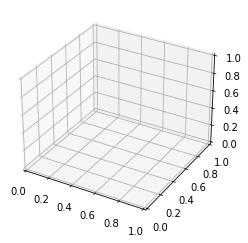

In [1]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))


from utils_general import utils_for_students

In [2]:
train_samples = utils_for_students.load_dataset_stage2('../data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('../data/stage2_ids_test.csv', 'test')

In [3]:
train_samples[0].keys()

dict_keys(['path', 'id', 'label', 'signer'])

In order to get a better grasp of every class in the dataset, we provide some additional information here.

There are 15 different classes. Each class corresponds to a sign. Signs can be annotated using sign glosses, which are representations of signs in written form in a spoken language. In the below table, we list all glosses, the English meaning of the corresponding sign, and provide a link to the Flemish sign language dictionary so that you can see an example performance of that sign.

| Gloss             | English meaning | Dictionary URL                                                                                        |
|-------------------|-----------------|-------------------------------------------------------------------------------------------------------|
| c.AF              | Done, finished  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AF/AF-B-209.mp4          |
| c.OOK             | Too, also       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/OO/OOK-A-8491.mp4        |
| ZELFDE-A          | The same        | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/ZE/ZELFDE-A-14290.mp4    |
| AUTO-RIJDEN-A     | To drive a car  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/RI/RIJDEN-C-9982.mp4     |
| HEBBEN-A          | To have         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HE/HEBBEN-A-4801.mp4     |
| HAAS-oor          | Hare            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HA/HAAS-B-16147.mp4      |
| AANKOMEN-A        | To arrive       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AA/AANKOMEN-A-39.mp4     |
| SCHILDPAD-Bhanden | Turtle          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/SC/SCHILDPAD-A-10503.mp4 |
| WAT-A             | What            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/WA/WAT-A-13657.mp4       |
| c.ZIEN            | To see          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/BE/BEKIJKEN-A-1157.mp4   |
| NAAR-A            | Towards         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GA/GA-NAAR-A-4032.mp4    |
| MOETEN-A          | To must         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/MO/MOETEN-D-17652.mp4    |
| C: 1              | 1               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/1-/1-A-15277.mp4         |
| GOED-A            | Good            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GO/GOED-C-4413.mp4       |
| C: 2              | 2               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/2-/2-A-15278.mp4         |

In [4]:
def move_hands_to_wrists(pose_sequence):
    new_pose_sequence = []
    for frame in pose_sequence:
        # HAND_WRISTS = [83,104] BODY_WRISTS = [15,16]
        dist_vect_left = frame[83] - frame[15]
        dist_vect_right = frame[104] - frame[16]
        new_frame = frame.copy()
        new_frame[83:104] -= dist_vect_left
        new_frame[104:125] -= dist_vect_right
        new_pose_sequence.append(new_frame)
    return np.array(new_pose_sequence)

In [5]:
from utils_feature_preprocessing.transform_frames import transform_to_k_frames, frames_to_features
from utils_feature_preprocessing.correct_zeros_interpolation import correct_zeros_interpolation
from utils_feature_preprocessing.enlarge_hands import enlarge_hands

def transform(pose_sequence, k):
    pose_sequence = correct_zeros_interpolation(pose_sequence)
    pose_sequence = transform_to_k_frames(pose_sequence, k=k)
    pose_sequence = move_hands_to_wrists(pose_sequence)
    return pose_sequence
    

In [6]:
# Concatenate the training set features.
X_train = []
y_train = []
K = 4

for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))
    X_train.append(transform(pose_sequence, k=K))
    y_train.append(sample['label'])
    
# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)


In [10]:
from scipy.spatial.transform import Rotation as R
from scipy.linalg import expm, norm
import math

def translate_frame(frame, trans_vector):
        translated_frame = np.empty_like(frame)
        for i in range(len(frame)):
            translated_frame[i,:] = frame[i,:] + trans_vector
        return translated_frame

def rotate_around(point, angle, axis):
#     rotation_vector = angle * axis
#     rotation = R.from_rotvec(rotation_vector)
#     return rotation.apply(point)
    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / math.sqrt(np.dot(axis, axis))
        a = math.cos(theta / 2.0)
        b, c, d = -axis * math.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

    return np.dot(rotation_matrix(axis, angle), point)


def rotate_frame(frame, angle, axis):
    rotated_frame = np.empty_like(frame)
    for i in range(len(frame)):
        rotated_frame[i,:] = rotate_around(frame[i], angle, axis) 
    return rotated_frame


def straighten_pose(frame):
    shoulder_avg = (frame[11]+frame[12])/2
    shoulder_dir = (frame[11]-frame[12])/np.linalg.norm(frame[11]-frame[12]) #length 1
    straight_shoulder_dir = [1,0,0]
    print(shoulder_dir, frame[11], frame[12])
    
    # angle_between = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]
    angle_between = np.arccos(np.dot(shoulder_dir, straight_shoulder_dir))
    
    # Normal on shoulder-straight_shoulderplane
    normal_vector = np.cross(shoulder_dir, straight_shoulder_dir)
    
    # Rotate around average of shoulder according to angle_between around normal_vectore 
    new_frame = translate_frame(frame, -shoulder_avg)
    new_frame = rotate_frame(new_frame, angle_between, normal_vector)
    new_frame = translate_frame(new_frame, shoulder_avg)
    
    return new_frame
    

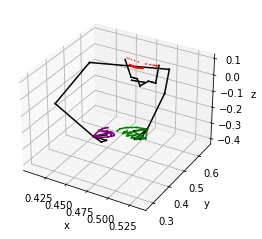

[ 0.77478121 -0.08762169  0.6261282 ] [0.51235212 0.43862531 0.08970309] [0.41831722 0.44925992 0.01371015]


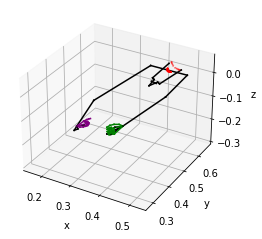

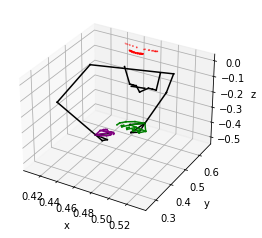

[ 0.78723261 -0.08047357  0.61138271] [ 0.51498047  0.43847158 -0.02289564] [ 0.41926595  0.44825584 -0.09722971]


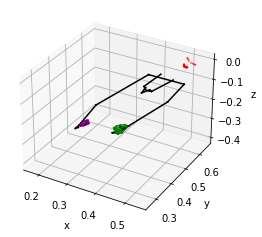

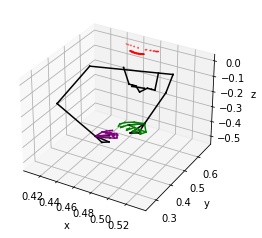

[ 0.76584124 -0.08695213  0.63712363] [ 0.51560328  0.43424665 -0.02356371] [ 0.41989901  0.44511273 -0.10318263]


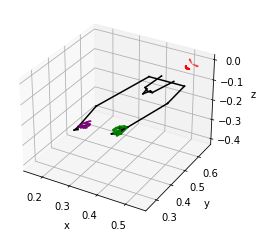

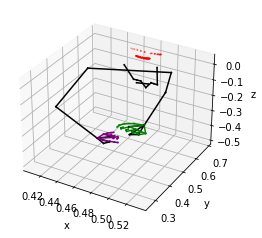

[ 0.67873776 -0.08728841  0.72917473] [0.5149069  0.43182209 0.01770549] [ 0.41929531  0.44411812 -0.08501099]


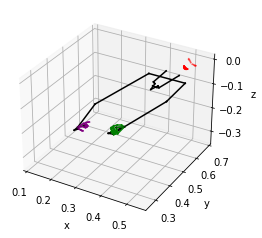

In [11]:
# Show all deames 
SAMPLE_INDEX = 17
for frame_index in range(len(X_train[SAMPLE_INDEX])):
    frame = X_train[SAMPLE_INDEX][frame_index]
    utils_for_students.visualize_pose_3d(frame, plt.axes(projection='3d'))
    plt.show()
    new_frame = straighten_pose(frame)
    utils_for_students.visualize_pose_3d(new_frame, plt.axes(projection='3d'))
    plt.show()
        

### Class histogram

In [12]:
from matplotlib import pyplot as plt
import pandas as pd

plt.figure(figsize = (10,5))
data_class = pd.DataFrame(label_encoder().inverse_transform(y_train))
unique, counts = np.unique(data_class, return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

TypeError: 'LabelEncoder' object is not callable

<Figure size 720x360 with 0 Axes>